In [1]:
from ipynb.fs.full.weather_pipeline import WeatherPipeline

In [2]:
# Configuration dictionary
config = {
    'data_path': './../data/',
    'file_name': 'weather_dataset_preprocesado.csv',
    #'columns_dataset': ['datetime', 'p (mbar)', 'T (degC)', 'Tpot (K)'], 
    'columns_dataset': ['datetime', 'T (degC)'], 
    'column_target': 'T (degC)',   
    'input_length': 24,
    'output_length': 4,
    'epochs': 20,
    'batch_size': 256,
    'learning_rate': 5e-4, #2.8e-4,
    'n_units': 256,
    'plot': True,
    'feature_engineering': False,
}

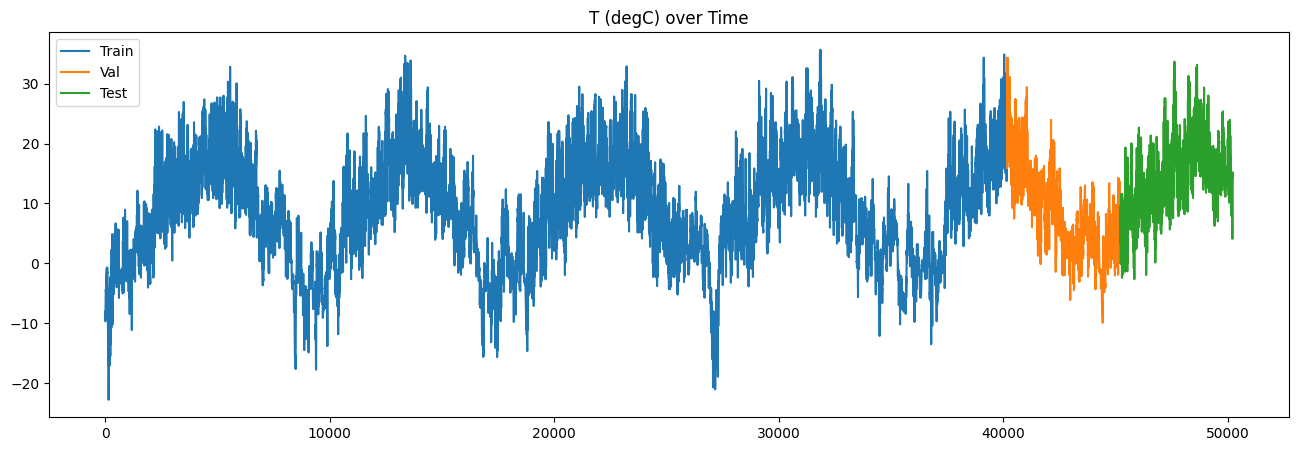

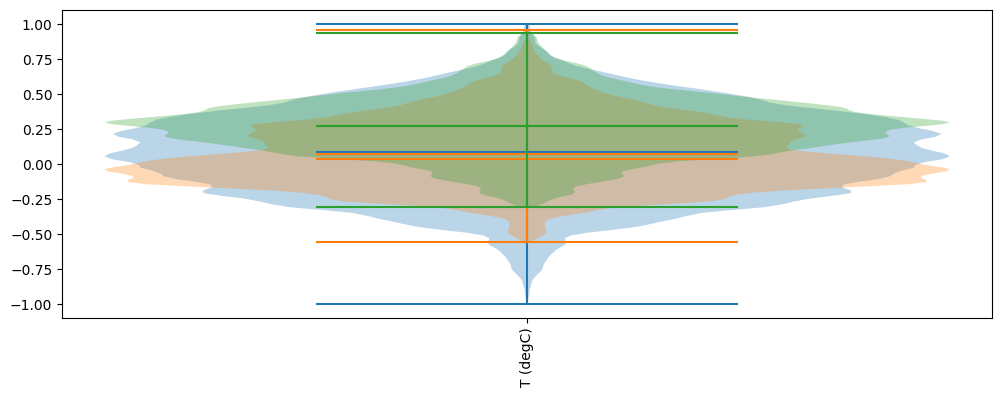

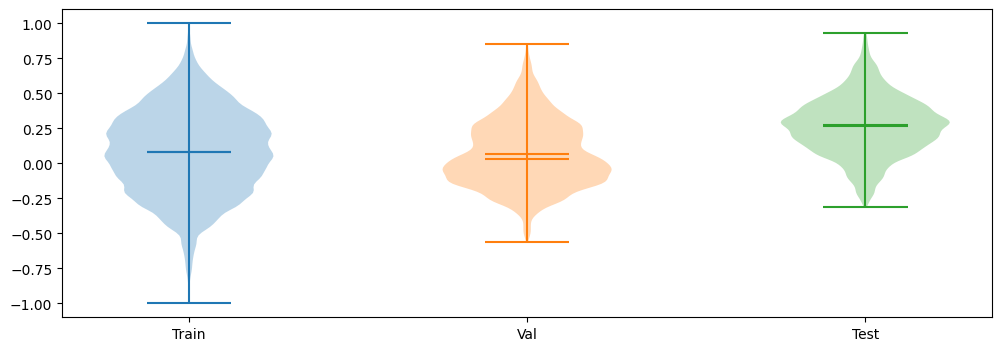

Epoch 1/20


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


157/157 - 31s - 201ms/step - loss: 0.1074 - val_loss: 0.0692 - learning_rate: 5.0000e-04
Epoch 2/20
157/157 - 30s - 192ms/step - loss: 0.0735 - val_loss: 0.0635 - learning_rate: 5.0000e-04
Epoch 3/20
157/157 - 30s - 193ms/step - loss: 0.0664 - val_loss: 0.0549 - learning_rate: 5.0000e-04
Epoch 4/20
157/157 - 33s - 208ms/step - loss: 0.0614 - val_loss: 0.0514 - learning_rate: 5.0000e-04
Epoch 5/20
157/157 - 31s - 199ms/step - loss: 0.0584 - val_loss: 0.0487 - learning_rate: 5.0000e-04
Epoch 6/20
157/157 - 32s - 204ms/step - loss: 0.0557 - val_loss: 0.0478 - learning_rate: 5.0000e-04
Epoch 7/20
157/157 - 37s - 233ms/step - loss: 0.0548 - val_loss: 0.0471 - learning_rate: 5.0000e-04
Epoch 8/20
157/157 - 33s - 207ms/step - loss: 0.0540 - val_loss: 0.0459 - learning_rate: 5.0000e-04
Epoch 9/20
157/157 - 33s - 213ms/step - loss: 0.0534 - val_loss: 0.0452 - learning_rate: 5.0000e-04
Epoch 10/20
157/157 - 33s - 211ms/step - loss: 0.0530 - val_loss: 0.0454 - learning_rate: 5.0000e-04
Epoch 11/2

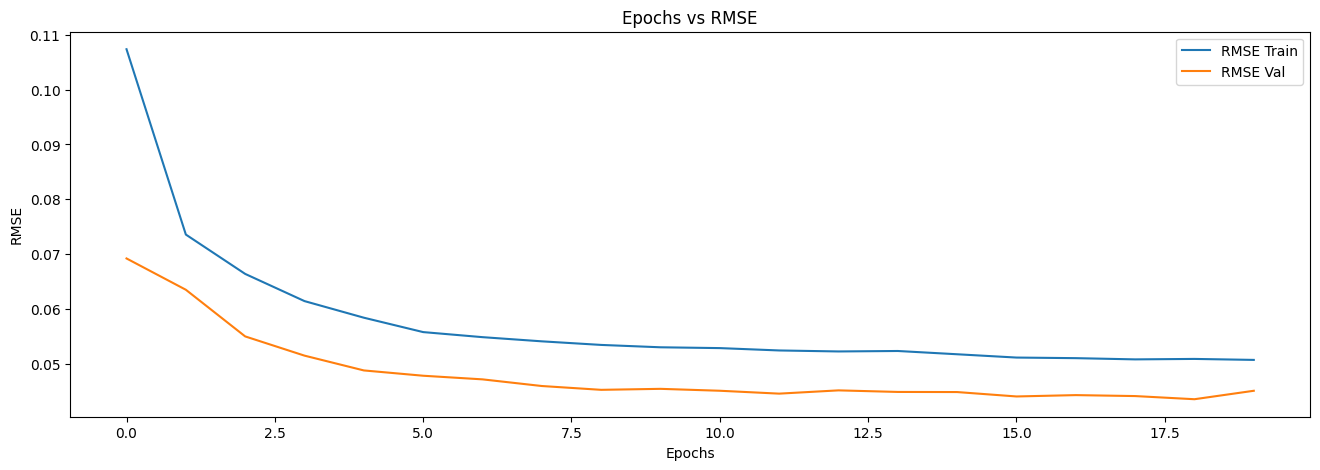

RMSE Comparison:
  RMSE Train: 0.045
  RMSE Val: 0.042
  RMSE Test: 0.049


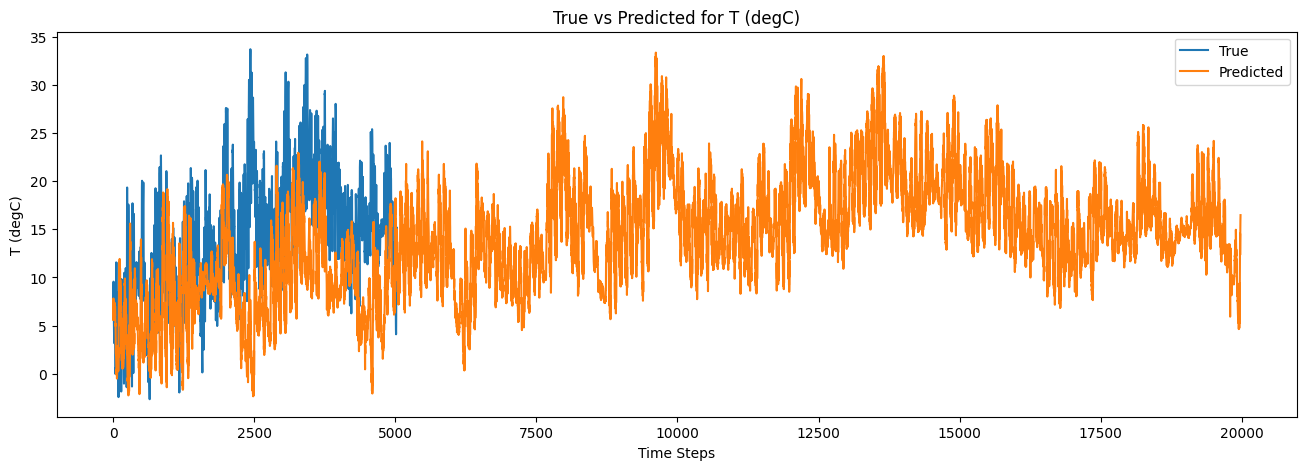

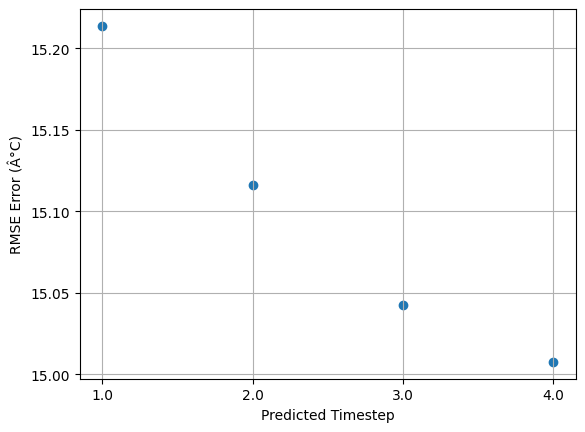

In [3]:
# Pipeline Execution
pipeline = WeatherPipeline(config)
pipeline.run()